Copyright © 2023, SAS Institute Inc., Cary, NC, USA.  All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Exams Dataset : Assess Bias of Regression Models and Import into Model Manager

This notebook provides an example of how to integrate bias assessment into the python model to SAS Model Manager (on either SAS Viya 3.5 or SAS Viya 4)  workflow using the exam data set [^1]. Lines of code that must be modified by the user, such as directory paths or the host server are noted with the comment "_Changes required by user._"

_**Note:** If you download only this notebook and not the rest of the repository, you must also download the exams.csv file from the data folder in the examples directory. These files are used when executing this notebook example._

Here are the steps shown in this notebook:

1. Import, review, and preprocess data for model training.
2. Build, train, and assess a scikit-learn models.
3. Create score tables for models.
4. Create JSON files for model assessment
5. Create other files necessary to import model into Model Manager (pickle files, metadata JSON files, score code, etc.)
6. Zip the pickle, JSON, and score code files into an archive file.
7. Import the ZIP archive file to SAS Model Manager via the Session object and relevant function call.

[^1]: source: http://roycekimmons.com/tools/generated_data/exams

## Import Modules

In [102]:
from sasctl import Session
import sasctl.pzmm as pzmm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import seaborn as sns
import numpy as np
from pathlib import Path
import regex as re

## Load, Examine, and Preprocess Data

In [2]:
df_raw = pd.read_csv('data/exams.csv')
df_raw.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,composite score
0,male,group B,some college,free/reduced,none,58,54,49,161
1,male,group B,some college,free/reduced,completed,58,58,60,176
2,male,group A,associate's degree,standard,none,35,42,35,112
3,male,group B,master's degree,free/reduced,none,89,88,85,262
4,male,group C,some high school,free/reduced,none,49,50,42,141


composite score                                               \
                         count        mean        std    min     25%    50%   
race/ethnicity                                                                
group A                    9.0  193.888889  52.629470  112.0  174.00  213.0   
group B                   17.0  188.588235  45.380418  102.0  161.00  175.0   
group C                   27.0  184.148148  43.685681   85.0  156.50  187.0   
group D                   31.0  205.064516  43.114526  114.0  175.00  199.0   
group E                   16.0  206.375000  28.504678  162.0  187.75  209.0   

                              
                  75%    max  
race/ethnicity                
group A         241.0  246.0  
group B         210.0  277.0  
group C         216.0  281.0  
group D         242.0  284.0  
group E         231.5  246.0

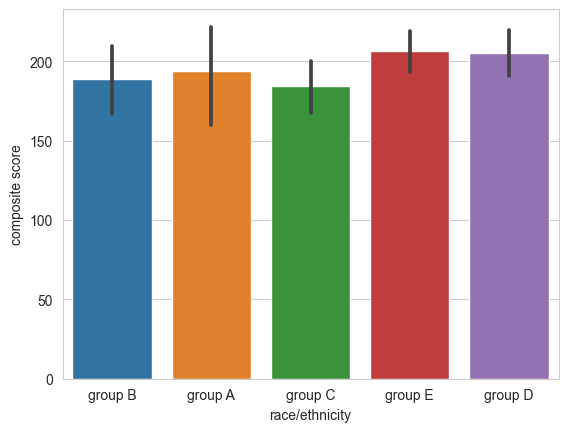

In [12]:
sns.barplot(df_raw, x='race/ethnicity', y='composite score')
df_raw[['race/ethnicity', 'composite score']].groupby('race/ethnicity').describe()

composite score                                                     \
                 count        mean        std    min    25%    50%    75%   
gender                                                                      
female            41.0  207.536585  35.531041  148.0  183.0  204.0  233.0   
male              59.0  187.677966  45.802590   85.0  158.0  183.0  223.0   

               
          max  
gender         
female  284.0  
male    281.0

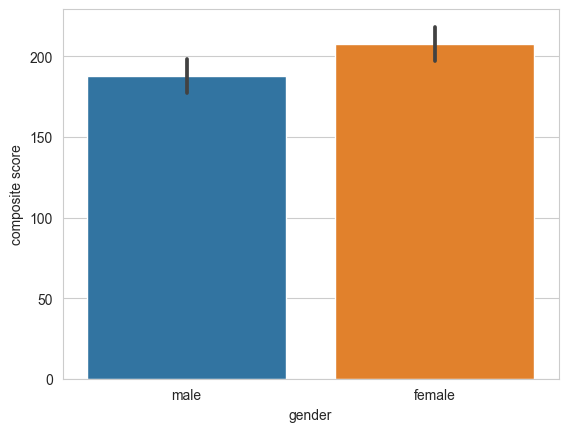

In [30]:
sns.barplot(df_raw, x='gender', y='composite score')
df_raw[['gender', 'composite score']].groupby('gender').describe()

In [4]:
df = df_raw.drop(['math score', 'reading score', 'writing score'], axis=1).dropna()
df = pd.get_dummies(df, columns=df.drop('composite score', axis=1).columns)
df = df.drop(['gender_female', 'race/ethnicity_group E', 'parental level of education_master\'s degree', 'lunch_standard', 'test preparation course_completed'], axis = 1)
df.head()

,composite score,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,parental level of education_associate's degree,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_some college,parental level of education_some high school,lunch_free/reduced,test preparation course_none
0,161,True,False,True,False,False,False,False,False,True,False,True,True
1,176,True,False,True,False,False,False,False,False,True,False,True,False
2,112,True,True,False,False,False,True,False,False,False,False,False,True
3,262,True,False,True,False,False,False,False,False,False,False,True,True
4,141,True,False,False,True,False,False,False,False,False,True,True,True


In [69]:
new_cols = []
for col in df.columns:
    col = col.replace('/', "")
    col = col.replace(" ", "_")
    col = col.replace("'", "")
    new_cols.append(col)

df.columns = new_cols

## Train Python Models

In [70]:
target = 'composite_score'
features = df.drop(target, axis = 1).columns

# train python models #
X_train, X_test, Y_train, Y_test = train_test_split(df[features], df[target], train_size=0.7, test_size=0.3,
                                                    random_state=42)

In [71]:
lr = LinearRegression()
rfr = RandomForestRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)

lr.fit(X_train, Y_train)
rfr.fit(X_train, Y_train)
gbr.fit(X_train, Y_train)

GradientBoostingRegressor(random_state=42)

## Assess Models

In [72]:
def sort_feature_importance(model, data):
    features = {}
    for importance, name in sorted(zip(model.feature_importances_, data.columns), reverse=True):
        features[name] = str(np.round(importance*100, 2)) + "%"
    return features

In [73]:
importances = pd.DataFrame.from_dict(sort_feature_importance(rfr, X_train), orient="index").rename(columns={0: "RandomForest"})
importances["GradientBoosting"] = pd.DataFrame.from_dict(sort_feature_importance(gbr, X_train), orient="index")
importances

,RandomForest,GradientBoosting
test_preparation_course_none,17.67%,20.43%
gender_male,12.08%,14.66%
lunch_freereduced,11.21%,10.38%
parental_level_of_education_high_school,9.35%,11.73%
parental_level_of_education_associates_degree,7.7%,11.0%
raceethnicity_group_D,7.51%,3.7%
raceethnicity_group_B,7.35%,7.97%
parental_level_of_education_some_high_school,6.92%,9.21%
raceethnicity_group_C,5.76%,3.8%
parental_level_of_education_some_college,5.65%,1.67%


In [101]:
metrics = {'LinearRegression': {'MSE': mean_squared_error(Y_test, lr.predict(X_test)),
                                  'MAE': mean_absolute_error(Y_test, lr.predict(X_test)),
                                  'RSQ': r2_score(Y_test, lr.predict(X_test))},
           'RandomForest': {'MSE': mean_squared_error(Y_test, rfr.predict(X_test)),
                                  'MAE': mean_absolute_error(Y_test, rfr.predict(X_test)),
                                  'RSQ': r2_score(Y_test, rfr.predict(X_test))},
           'GradientBoost': {'MSE': mean_squared_error(Y_test, gbr.predict(X_test)),
                                  'MAE': mean_absolute_error(Y_test, gbr.predict(X_test)),
                                  'RSQ': r2_score(Y_test, gbr.predict(X_test))}}

pd.DataFrame(metrics).transpose()

,MSE,MAE,RSQ
LinearRegression,1120.879483,26.721537,0.091752
RandomForest,1059.318005,23.818255,0.141636
GradientBoost,1359.523403,27.447378,-0.101621


## Create Score Tables

In [75]:
# reconstructing race/ethnicity variable
race = pd.from_dummies(X_test[['raceethnicity_group_A', 'raceethnicity_group_B', 'raceethnicity_group_C', 'raceethnicity_group_D']], sep='_', default_category={"raceethnicity": "group_E"})
race.head()

,raceethnicity
0,group_D
1,group_D
2,group_E
3,group_D
4,group_E


In [76]:
# recreating gender variable
gender = X_test['gender_male'].apply(lambda x: 'male' if x else 'female')
gender

83      male
53      male
70    female
45      male
44    female
39      male
22      male
80    female
10      male
0       male
18      male
30      male
73    female
33    female
90      male
4       male
76    female
77      male
12      male
31    female
55    female
88    female
26    female
42      male
69    female
15      male
40      male
96      male
9       male
72    female
Name: gender_male, dtype: object

In [77]:
def build_score_table(model):
    score_data = {'Predicted_Composite_Score': model.predict(X_test),
                  'Composite_Score': Y_test.to_numpy(),
                  'Race': race.to_numpy()[:,0],
                  'Gender': gender}
    data = pd.DataFrame(score_data)
    return data

In [78]:
score_tables = {"LinearRegression": build_score_table(lr),
                "RandomForest": build_score_table(rfr),
                "GradientBoost": build_score_table(gbr)}

In [79]:
for k,v in score_tables.items():
    print(f'{k} \n {v.head()}')

LinearRegression 
     Predicted_Composite_Score  Composite_Score     Race  Gender
83                 203.164794              199  group_D    male
53                 206.754746              264  group_D    male
70                 191.327416              163  group_E  female
45                 178.560747              160  group_D    male
44                 211.251022              193  group_E  female
RandomForest 
     Predicted_Composite_Score  Composite_Score     Race  Gender
83                 201.582417              199  group_D    male
53                 240.742000              264  group_D    male
70                 199.406667              163  group_E  female
45                 143.170667              160  group_D    male
44                 186.840000              193  group_E  female
GradientBoost 
     Predicted_Composite_Score  Composite_Score     Race  Gender
83                 223.756650              199  group_D    male
53                 232.962790              264  group_

## Get File Properties

In [80]:
# setting up environment
hostname = ''
username = ''
password = ''

sess = Session(hostname, username, password, protocol='http')

In [81]:
# Model names within SAS Model Manager
model_prefix = ["LinearRegression", "RandomForest", "GradientBoost"]
# Directory location for the model files
zip_folder = [Path.cwd() / "data/BiasMetrics/examModels/LinearRegression/",
             Path.cwd() / "data/BiasMetrics/examModels/RandomForest/",
             Path.cwd() / "data/BiasMetrics/examModels/GradientBoost"] # Changes required by user
model = [lr, rfr, gbr]
# Output variables expected in SAS Model Manager. If a classification value is expected to be output, it should be the first metric.
score_metrics = ["EM_PREDICTION"]

In [82]:
for (model, path) in zip(model_prefix, zip_folder):
    pzmm.JSONFiles.assess_model_bias(
        score_table=score_tables[model],
        actual_values='Composite_Score',
        sensitive_values=['Race', 'Gender'],
        pred_values='Predicted_Composite_Score',
        json_path=path
    )

before formatting: Predicted_Composite_Score    float64
Composite_Score                int64
Race                          object
Gender                        object
dtype: object
after formatting: Predicted_Composite_Score    float64
Composite_Score                int64
Race                          object
Gender                        object
dtype: object
maxDifferences.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\LinearRegression\maxDifferences.json
groupMetrics.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\LinearRegression\groupMetrics.json
before formatting: Predicted_Composite_Score    float64
Composite_Score                int64
Race                          object
Gender                        object
dtype: object
after formatting: Predicted_Composite_Score    float64
Composite_Score                int64
Race          

In [83]:
for (mod, prefix, path) in zip(model, model_prefix, zip_folder):
    pzmm.PickleModel.pickle_trained_model(
        model_prefix=prefix,
        trained_model=mod,
        pickle_path=path
    )

Model LinearRegression was successfully pickled and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\LinearRegression\LinearRegression.pickle.
Model RandomForest was successfully pickled and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\RandomForest\RandomForest.pickle.
Model GradientBoost was successfully pickled and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\GradientBoost\GradientBoost.pickle.


In [84]:
def write_json_files(data, predict, target, path, prefix):
    # Write input variable mapping to a json file
    pzmm.JSONFiles.write_var_json(input_data=data[predict], is_input=True, json_path=path)

    # Set output variables and assign an event threshold, then write output variable mapping
    output_var = pd.DataFrame(columns=score_metrics, data=[[0.5]]) # data argument includes example expected types for outputs
    pzmm.JSONFiles.write_var_json(output_var, is_input=False, json_path=path)

    # Write model properties to a json file
    pzmm.JSONFiles.write_model_properties_json(
        model_name=prefix,
        target_variable=target, # Target variable to make predictions about
        json_path=path,
        model_desc=f"Description for the {prefix} model.",
        model_algorithm="",
        modeler="sasdemo",
    )

    # Write model metadata to a json file so that SAS Model Manager can properly identify all model files
    pzmm.JSONFiles.write_file_metadata_json(model_prefix=prefix, json_path=path)

for (prefix, path) in zip(model_prefix, zip_folder):
    write_json_files(df, features, target, path, prefix)

inputVar.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\LinearRegression\inputVar.json
outputVar.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\LinearRegression\outputVar.json
ModelProperties.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\LinearRegression\ModelProperties.json
fileMetadata.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\LinearRegression\fileMetadata.json
inputVar.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\RandomForest\inputVar.json
outputVar.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\RandomForest\o

In [86]:
for (prefix, path) in zip(model_prefix, zip_folder):
    pzmm.ImportModel.import_model(
        model_files=path, # Where are the model files?
        model_prefix=prefix, # What is the model name?
        project="ExamModels", # What is the project name?
        input_data=df[features], # What does example input data look like?
        predict_method=[lr.predict, [float]], # What is the predict method and what does it return?
        score_metrics=score_metrics, # What are the output variables?
        overwrite_model=True, # Overwrite the model if it already exists?
        model_file_name=prefix + ".pickle", # How was the model file serialized?
        missing_values=True # Does the data include missing values?
    )

Model score code was written successfully to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\LinearRegression\score_LinearRegression.py and uploaded to SAS Model Manager.
All model files were zipped to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\LinearRegression.


C:\Users\elmcfa\PycharmProjects\python-sasctl\src\sasctl\pzmm\import_model.py:45: UserWarning: No project with the name or UUID ExamModels was found.
  warn(f"No project with the name or UUID {project} was found.")


A new project named ExamModels was created.
Model was successfully imported into SAS Model Manager as LinearRegression with the following UUID: 4c30c311-5547-4a52-a554-7e2dcfa64d52.
Model score code was written successfully to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\RandomForest\score_RandomForest.py and uploaded to SAS Model Manager.
All model files were zipped to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\RandomForest.
Model was successfully imported into SAS Model Manager as RandomForest with the following UUID: 4716069f-8931-41b0-98e0-bfae626d34ea.
Model score code was written successfully to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\GradientBoost\score_GradientBoost.py and uploaded to SAS Model Manager.
All model files were zipped to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\examModels\GradientBoost.
Model was successfully import